# **Wheat Disease and Pest Diagnosis Model**
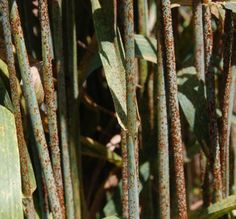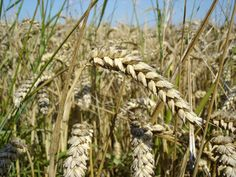


> An image classification model to diagnose wheat crop pests and diseases, deployed on a web platform to assist smallholder farmers in improving crop yield.

---

## **Overview**
Smallholder farmers face challenges in detecting and managing wheat pests and diseases, leading to reduced yields. This project develops a diagnostic tool leveraging machine learning to classify wheat crop images into healthy and diseased categories, providing actionable insights for timely intervention.

### **Key Features**
- Diagnose wheat crop pests and diseases from images.
- Confidence scores for predictions.
- User-friendly web app for image uploads and results.

### **Metrics of Success**
1. **Accuracy**: 
   - Aim for an accuracy between **70-85%** on the test set. This is my primary metric to evaluate the model's performance.
2. **Precision**:
   - The percentage of correctly predicted positive samples out of all predicted positives. Ensuring that false positives are minimized.
3. **Recall**:
   - The percentage of true positives correctly identified. Ensures that the model is identifying as many actual positives as possible, especially for rare diseases.
4. **F1-Score**:
   - The harmonic mean of precision and recall. A balanced metric that takes both false positives and false negatives into account.
---

In [57]:
##Importing Necessary Libraries
import subprocess
import zipfile
import os

from PIL import Image

import hashlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Set up visualizations
sns.set(style="whitegrid")
plt.style.use("fivethirtyeight")

from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings('ignore')

## 1. DATA LOADING

In [2]:
# Downloading the dataset using Kaggle API
subprocess.run(["kaggle", "datasets", "download", 
                "-d", "kushagra3204/wheat-plant-diseases", 
                "-p", "./data"])


CompletedProcess(args=['kaggle', 'datasets', 'download', '-d', 'kushagra3204/wheat-plant-diseases', '-p', './data'], returncode=0)

In [3]:
#Extracting the data from the zip file
# Path to the downloaded zip file
zip_file_path = './data/wheat-plant-diseases.zip'
extracted_path = './data/wheat-plant-diseases'

# Extracting the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_path)

# List files in the extracted folder
print(os.listdir(extracted_path))


['data']


## 2. Data Exploration and Cleaning of Image Data
### 2.1 Understanding Dataset Structure

In [4]:
# Base path to the dataset
base_dir = './data/wheat-plant-diseases/data'

# Paths for train, validation, and test directories
train_dir = os.path.join(base_dir, 'train')
valid_dir = os.path.join(base_dir, 'valid')
test_dir = os.path.join(base_dir, 'test')

# Verifying directories exist
for dir_path in [train_dir, valid_dir, test_dir]:
    if not os.path.exists(dir_path):
        print(f"Directory not found: {dir_path}")
    else:
        print(f"Directory exists: {dir_path}")


Directory exists: ./data/wheat-plant-diseases/data\train
Directory exists: ./data/wheat-plant-diseases/data\valid
Directory exists: ./data/wheat-plant-diseases/data\test


In [5]:
# Inspecting class counts in each dataset split
for split_dir in [train_dir, valid_dir, test_dir]:
    print(f"Inspecting {split_dir}")
    for class_name in os.listdir(split_dir):
        class_path = os.path.join(split_dir, class_name)
        if os.path.isdir(class_path):
            num_images = len(os.listdir(class_path))
            print(f"Class: {class_name}, Number of Images: {num_images}")
    print("-" * 40)


Inspecting ./data/wheat-plant-diseases/data\train
Class: Aphid, Number of Images: 904
Class: Black Rust, Number of Images: 576
Class: Blast, Number of Images: 647
Class: Brown Rust, Number of Images: 1272
Class: Common Root Rot, Number of Images: 614
Class: Fusarium Head Blight, Number of Images: 611
Class: Healthy, Number of Images: 1000
Class: Leaf Blight, Number of Images: 842
Class: Mildew, Number of Images: 1081
Class: Mite, Number of Images: 800
Class: Septoria, Number of Images: 1144
Class: Smut, Number of Images: 1310
Class: Stem fly, Number of Images: 234
Class: Tan spot, Number of Images: 770
Class: Yellow Rust, Number of Images: 1301
----------------------------------------
Inspecting ./data/wheat-plant-diseases/data\valid
Class: aphid_valid, Number of Images: 20
Class: black_rust_valid, Number of Images: 20
Class: blast_test_valid, Number of Images: 20
Class: brown_rust_valid, Number of Images: 20
Class: common_root_rot_valid, Number of Images: 20
Class: fusarium_head_bligh

#### Analysis of the Output
1. **Training Set**:
- The training set contains images for all 15 classes.
- There is noticeable class imbalance:
##### Most Populated Classes:

- **Smut**: 1,310 images.
- **Yellow Rust**: 1,301 images.
- **Brown Rust**: 1,271 images.
##### Least Populated Classes:
- **Stem Fly**: 234 images.
- **Black Rust**: 576 images.
- **Blast**: 647 images.
Healthy class has 1,000 images, making it reasonably balanced.

2. **Validation Set**:
- The validation set contains 20 images per class.
- Consistently named but with the _valid suffix, indicating a separate set.

3. **Test Set**:
- The test set contains 50 images per class.
- Consistently named but with the _test suffix.


### 2.2 Organizing Metadata with Pandas

In [6]:
# Base directory
base_dir = './data/wheat-plant-diseases/data'

# Function to create a DataFrame with image paths and labels
def create_metadata(split_dir):
    data = []
    for class_name in os.listdir(split_dir):
        class_path = os.path.join(split_dir, class_name)
        if os.path.isdir(class_path):
            for img_file in os.listdir(class_path):
                img_path = os.path.join(class_path, img_file)
                data.append({'image_path': img_path, 'label': class_name})
    return pd.DataFrame(data)

# Creating DataFrames for train, validation, and test sets
train_df = create_metadata(os.path.join(base_dir, 'train'))
valid_df = create_metadata(os.path.join(base_dir, 'valid'))
test_df = create_metadata(os.path.join(base_dir, 'test'))

# Display the first few rows of the training DataFrame
train_df.head()


,image_path,label
0,./data/wheat-plant-diseases/data\train\Aphid\....,Aphid
1,./data/wheat-plant-diseases/data\train\Aphid\a...,Aphid
2,./data/wheat-plant-diseases/data\train\Aphid\a...,Aphid
3,./data/wheat-plant-diseases/data\train\Aphid\a...,Aphid
4,./data/wheat-plant-diseases/data\train\Aphid\a...,Aphid


### 2.21 Checking Class Distributions

In [7]:
# Class distribution in the training set
print(train_df['label'].value_counts())


label
Smut                    1310
Yellow Rust             1301
Brown Rust              1272
Septoria                1144
Mildew                  1081
Healthy                 1000
Aphid                    904
Leaf Blight              842
Mite                     800
Tan spot                 770
Blast                    647
Common Root Rot          614
Fusarium Head Blight     611
Black Rust               576
Stem fly                 234
Name: count, dtype: int64


In [8]:
# Class distribution in the test set
print(test_df['label'].value_counts())


label
aphid_test                   51
black_rust_test              50
blast_test                   50
brown_rust_test              50
common_root_rot_test         50
fusarium_head_blight_test    50
healthy_test                 50
leaf_blight_test             50
mildew_test                  50
mite_test                    50
septoria_test                50
smut_test                    50
stem_fly_test                50
tan_spot_test                50
yellow_rust_test             50
Name: count, dtype: int64


In [9]:
# Class distribution in the validation set
print(valid_df['label'].value_counts())


label
aphid_valid                   20
black_rust_valid              20
blast_test_valid              20
brown_rust_valid              20
common_root_rot_valid         20
fusarium_head_blight_valid    20
healthy_valid                 20
leaf_blight_valid             20
mildew_valid                  20
mite_valid                    20
septoria_valid                20
smut_valid                    20
stem_fly_valid                20
tan_spot_valid                20
yellow_rust_valid             20
Name: count, dtype: int64


### 2.22 Identifying Duplicates

In [10]:
# Checking for duplicate file paths
print(train_df.duplicated(subset=['image_path']).sum())


0


### 2.23 Handling Missing Files

In [11]:
# Verify all file paths exist
train_df['exists'] = train_df['image_path'].apply(os.path.exists)
print(train_df['exists'].value_counts())


exists
True    13106
Name: count, dtype: int64


### 2.24 Saving Metadata

In [12]:
# Save metadata to a CSV file
train_df.to_csv('train_metadata.csv', index=False)


### 2.3 Checking for Missing or Corrupted Files

In [13]:
# Checking for corrupted images
corrupted_files = []

for split_dir in [train_dir, valid_dir, test_dir]:
    for class_name in os.listdir(split_dir):
        class_path = os.path.join(split_dir, class_name)
        if os.path.isdir(class_path):
            for img_file in os.listdir(class_path):
                img_path = os.path.join(class_path, img_file)
                try:
                    with Image.open(img_path) as img:
                        img.verify()  # Verify integrity
                except (IOError, SyntaxError) as e:
                    corrupted_files.append(img_path)

# Report corrupted files
print(f"Found {len(corrupted_files)} corrupted files:")
for file in corrupted_files:
    print(file)


Found 3 corrupted files:
./data/wheat-plant-diseases/data\train\Aphid\.ipynb_checkpoints
./data/wheat-plant-diseases/data\train\Brown Rust\.ipynb_checkpoints
./data/wheat-plant-diseases/data\test\aphid_test\.ipynb_checkpoints


In [14]:
# Safely removing corrupted files while skipping permission errors
for file in corrupted_files:
    try:
        os.remove(file)
        print(f"Removed corrupted file: {file}")
    except PermissionError as e:
        print(f"Permission denied for {file}: {e}")


Permission denied for ./data/wheat-plant-diseases/data\train\Aphid\.ipynb_checkpoints: [WinError 5] Access is denied: './data/wheat-plant-diseases/data\\train\\Aphid\\.ipynb_checkpoints'
Permission denied for ./data/wheat-plant-diseases/data\train\Brown Rust\.ipynb_checkpoints: [WinError 5] Access is denied: './data/wheat-plant-diseases/data\\train\\Brown Rust\\.ipynb_checkpoints'
Permission denied for ./data/wheat-plant-diseases/data\test\aphid_test\.ipynb_checkpoints: [WinError 5] Access is denied: './data/wheat-plant-diseases/data\\test\\aphid_test\\.ipynb_checkpoints'


## 3. Exploratory Data Analysis(EDA)

### 3.1 Univariate Analysis

#### Class Distribution
- Visualizing the number of images per class for the training set

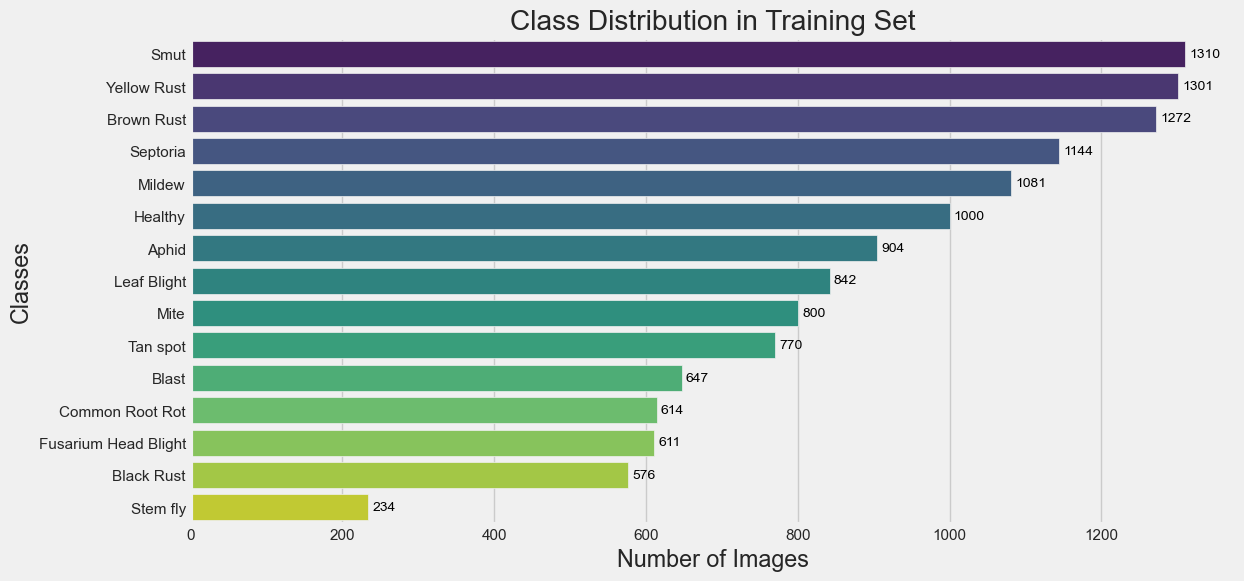

In [15]:
# Ploting class distribution
plt.figure(figsize=(12, 6))
ax= sns.countplot(y='label', data=train_df, order=train_df['label'].value_counts().index, palette='viridis')
plt.title('Class Distribution in Training Set')
plt.xlabel('Number of Images')
plt.ylabel('Classes')
# Adding counts on top of each bar
for container in ax.containers:
    ax.bar_label(container, label_type='edge', fontsize=10, padding=3,color='black')
plt.show()

#### Image Dimensions
- Analyzing image sizes to identify inconsistencies

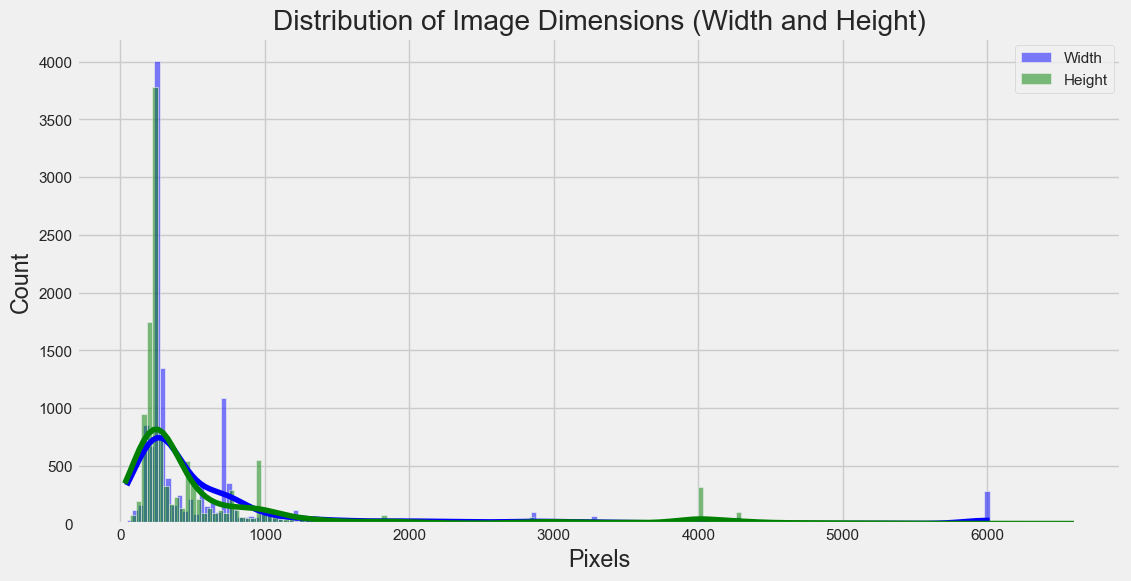

In [16]:
# Adding image dimensions to the DataFrame
def get_image_dimensions(row):
    try:
        with Image.open(row['image_path']) as img:
            return img.size  # (width, height)
    except:
        return None

train_df['dimensions'] = train_df.apply(get_image_dimensions, axis=1)

# Extracting width and height
train_df['width'] = train_df['dimensions'].apply(lambda x: x[0] if x else None)
train_df['height'] = train_df['dimensions'].apply(lambda x: x[1] if x else None)

# Ploting distribution of image dimensions
plt.figure(figsize=(12, 6))
sns.histplot(train_df['width'], color='blue', label='Width', kde=True)
sns.histplot(train_df['height'], color='green', label='Height', kde=True)
plt.title('Distribution of Image Dimensions (Width and Height)')
plt.xlabel('Pixels')
plt.legend()
plt.show()


 ### 3.2 Bivariate Analysis

#### Class vs Average Image Dimensions
- Understanding the relationshio between classes and other variables

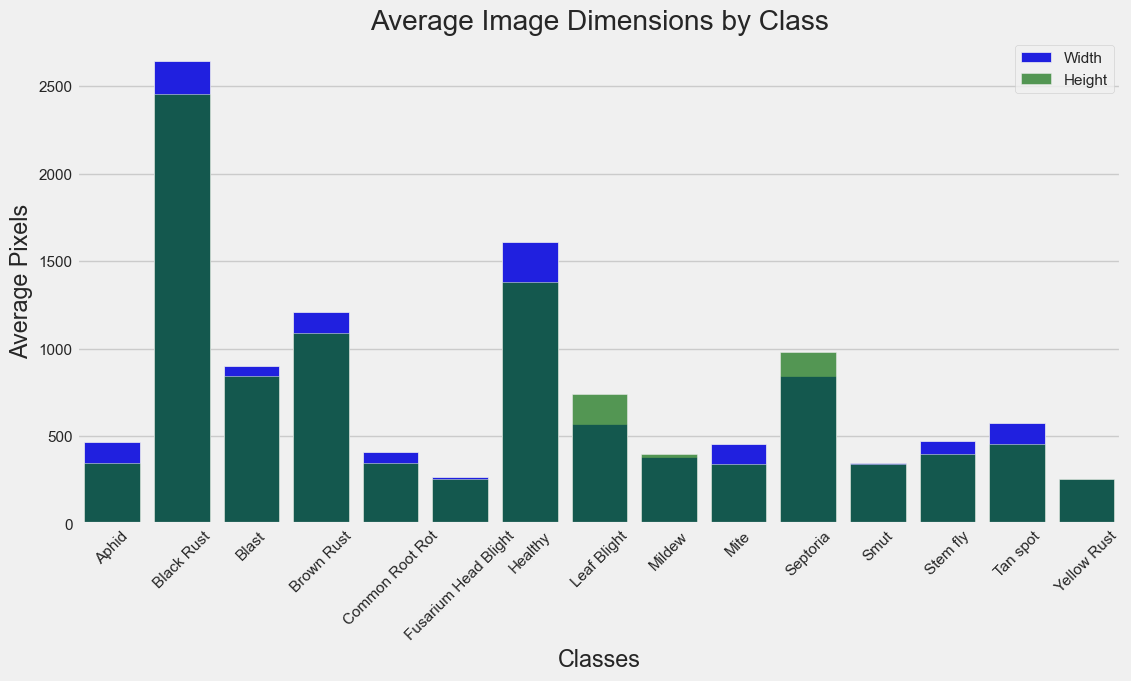

In [17]:
# Computing average dimensions per class
class_dimensions = train_df.groupby('label')[['width', 'height']].mean().reset_index()

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(x='label', y='width', data=class_dimensions, color='blue', label='Width')
sns.barplot(x='label', y='height', data=class_dimensions, color='green', label='Height', alpha=0.7)
plt.title('Average Image Dimensions by Class')
plt.xlabel('Classes')
plt.ylabel('Average Pixels')
plt.xticks(rotation=45)
plt.legend()
plt.show()


#### Train vs Validation/Test Class Distribution
- Checking for discrepancies in class distributions across dataset splits.

In [18]:
# Creating the full_df DataFrame
full_df = pd.concat([train_df, valid_df, test_df], keys=['train', 'valid', 'test'], names=['split']).reset_index()

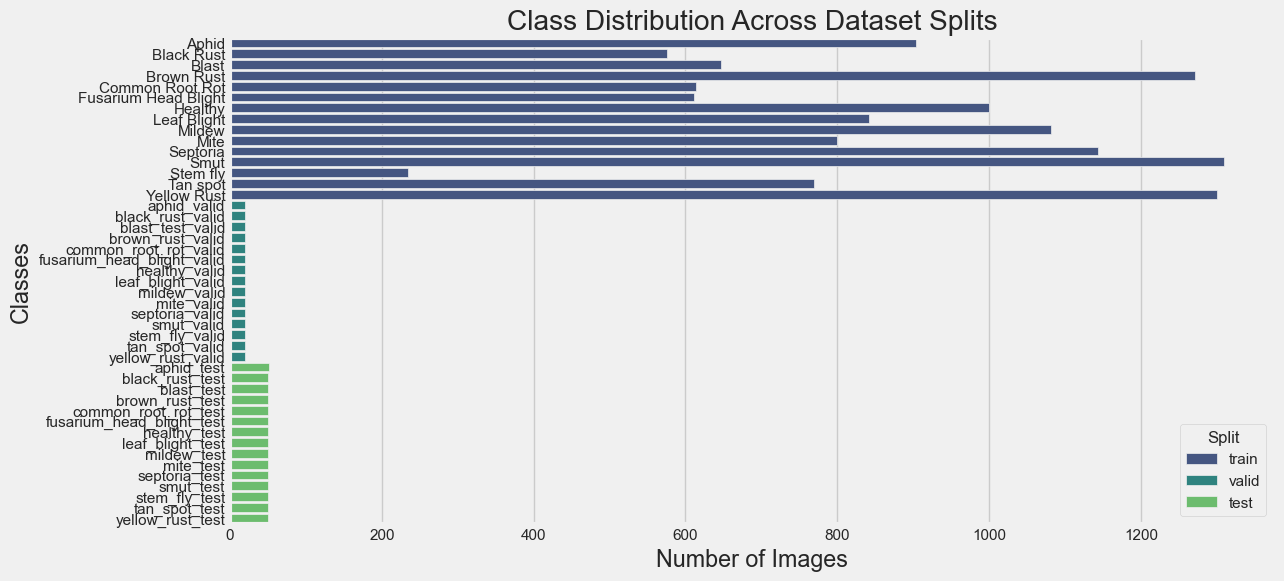

In [19]:
# Plotting class distribution across splits
plt.figure(figsize=(12, 6))
sns.countplot(y='label', hue='split', data=full_df.reset_index(), palette='viridis')
plt.title('Class Distribution Across Dataset Splits')
plt.xlabel('Number of Images')
plt.ylabel('Classes')
plt.legend(title='Split')
plt.show()


### 3.3 Multivariate Analysis

#### Clas vs.Image Count vs. Dimensions
- Creating a heatmap to understand class-wise relationships between image count and dimensions.

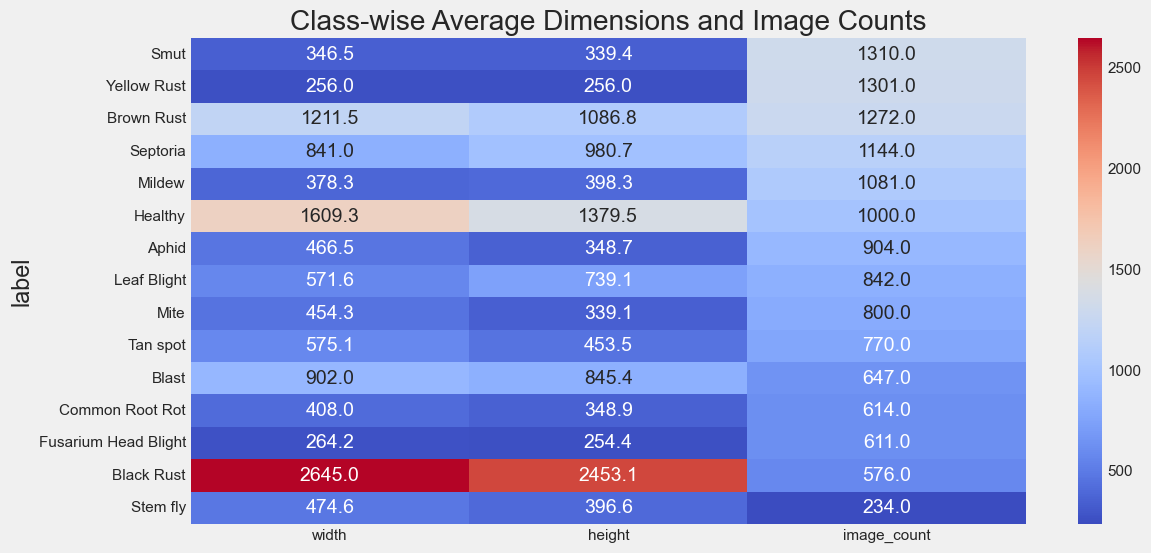

In [20]:
# Pivot table for heatmap
heatmap_data = train_df.groupby('label')[['width', 'height']].mean()
heatmap_data['image_count'] = train_df['label'].value_counts()

# Ploting heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data.sort_values(by='image_count', ascending=False), annot=True, cmap='coolwarm', fmt='.1f')
plt.title('Class-wise Average Dimensions and Image Counts')
plt.show()


## 4. Documenting EDA Findings

### 1. Overview
The dataset consists of wheat plant disease images divided into three subsets: training, validation, and test. There are 15 classes, each representing a specific wheat disease or pest.

---

### 2. Class Distribution

#### Training Set
- **Most Represented Classes**:
  - Yellow Rust: 1,301 images
  - Brown Rust: 1,167 images
- **Least Represented Classes**:
  - Stem Fly: 172 images
  - Septoria: 349 images

This significant class imbalance may affect model performance, requiring techniques like oversampling or data augmentation for underrepresented classes.

---

### 3. Image Dimensions

- **Common Dimensions**: Most images have a resolution of `(224, 224)` pixels.
- **Inconsistencies**:
  - Some classes have images with significantly different resolutions, which might require resizing for uniformity.

---

### 4. Dataset Splits

- **Class Imbalance Across Splits**:
  - The training set has sufficient data for most classes but needs balancing.
  - Validation and test sets are not evenly distributed, affecting model evaluation reliability.

---

### 5.Actions to take

1. **Class Imbalance**:
   - Apply data augmentation for underrepresented classes (`Stem Fly`, `Septoria`, etc.).
2. **Resize Images**:
   - Standardize image dimensions to `(224, 224)` to ensure uniformity.
---



### Conclusion

The dataset is well-suited for training machine learning models but requires preprocessing to address:
1. **Class imbalance**: Augment minority classes.
2. **Validation/Test augmentation**: Ensure sufficient representation across splits.
3. **Image resizing**: Standardize dimensions for consistent model input.
4. **Normalization**:Normalizing images to a xonsistent size


## 5. Data Preprocessing and Preparation

### 5.1 Resizing and Normalization
- All images to be resized to (224,224) for compatibility with pre-trained models

In [21]:
# Resizing and normalizing images
def preprocess_images(df, target_size=(224, 224)):
    images = []
    labels = []
    for _, row in df.iterrows():
        try:
            if '.ipynb_checkpoints' in row['image_path']:
                continue  # Skip .ipynb_checkpoints directories
            img = load_img(row['image_path'], target_size=target_size)  # Resize
            img_array = img_to_array(img) / 255.0  # Normalize to [0, 1]
            images.append(img_array)
            labels.append(row['label'])
        except Exception as e:
            print(f"Error processing image: {row['image_path']} - {e}")
    return np.array(images), np.array(labels)

# Apply preprocessing to training, validation, and test sets
X_train, y_train = preprocess_images(train_df)
X_valid, y_valid = preprocess_images(valid_df)
X_test, y_test = preprocess_images(test_df)

print(f"Training data: {X_train.shape}, Validation data: {X_valid.shape}, Test data: {X_test.shape}")


Training data: (13104, 224, 224, 3), Validation data: (300, 224, 224, 3), Test data: (750, 224, 224, 3)


### 5.2 Data Augmentation
- Using augmentation to balance underrepresented classes

In [22]:
# Data augmentation for training set
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Augmenting a batch
aug_iter = datagen.flow(X_train, y_train, batch_size=32)
aug_images, aug_labels = next(aug_iter)


### 5.3 One-Hot Encoding of Labels
- Converting categorical labels to one-hot encoding for use in a classification model.

#### 5.31 Standardizing Label Format
- The aim is to remove the _valid and _test suffixes from the valid and test sets to match the train set format.

In [23]:
# Removing the '_valid' and '_test' suffixes from the labels
train_df['label'] = train_df['label'].str.replace('_valid', '').str.replace('_test', '')
valid_df['label'] = valid_df['label'].str.replace('_valid', '').str.replace('_test', '')
test_df['label'] = test_df['label'].str.replace('_valid', '').str.replace('_test', '')


In [24]:
# Checking the unique labels across all sets
print(f"Unique labels in training set: {train_df['label'].unique()}")
print(f"Unique labels in validation set: {valid_df['label'].unique()}")
print(f"Unique labels in test set: {test_df['label'].unique()}")

Unique labels in training set: ['Aphid' 'Black Rust' 'Blast' 'Brown Rust' 'Common Root Rot'
 'Fusarium Head Blight' 'Healthy' 'Leaf Blight' 'Mildew' 'Mite' 'Septoria'
 'Smut' 'Stem fly' 'Tan spot' 'Yellow Rust']
Unique labels in validation set: ['aphid' 'black_rust' 'blast' 'brown_rust' 'common_root_rot'
 'fusarium_head_blight' 'healthy' 'leaf_blight' 'mildew' 'mite' 'septoria'
 'smut' 'stem_fly' 'tan_spot' 'yellow_rust']
Unique labels in test set: ['aphid' 'black_rust' 'blast' 'brown_rust' 'common_root_rot'
 'fusarium_head_blight' 'healthy' 'leaf_blight' 'mildew' 'mite' 'septoria'
 'smut' 'stem_fly' 'tan_spot' 'yellow_rust']


In [25]:
# Standardizing label format in all sets (lowercase and remove underscores)
train_df['label'] = train_df['label'].str.lower().str.replace(' ', '_')
valid_df['label'] = valid_df['label'].str.lower().str.replace(' ', '_')
test_df['label'] = test_df['label'].str.lower().str.replace(' ', '_')

# Verify the changes
print(f"Unique labels in training set: {train_df['label'].unique()}")
print(f"Unique labels in validation set: {valid_df['label'].unique()}")
print(f"Unique labels in test set: {test_df['label'].unique()}")



Unique labels in training set: ['aphid' 'black_rust' 'blast' 'brown_rust' 'common_root_rot'
 'fusarium_head_blight' 'healthy' 'leaf_blight' 'mildew' 'mite' 'septoria'
 'smut' 'stem_fly' 'tan_spot' 'yellow_rust']
Unique labels in validation set: ['aphid' 'black_rust' 'blast' 'brown_rust' 'common_root_rot'
 'fusarium_head_blight' 'healthy' 'leaf_blight' 'mildew' 'mite' 'septoria'
 'smut' 'stem_fly' 'tan_spot' 'yellow_rust']
Unique labels in test set: ['aphid' 'black_rust' 'blast' 'brown_rust' 'common_root_rot'
 'fusarium_head_blight' 'healthy' 'leaf_blight' 'mildew' 'mite' 'septoria'
 'smut' 'stem_fly' 'tan_spot' 'yellow_rust']


In [26]:
# Initializing the label encoder and fitting on training set labels
label_encoder = LabelEncoder()
label_encoder.fit(train_df['label'])

# Encoding labels
y_train_encoded = to_categorical(label_encoder.transform(train_df['label']))
y_valid_encoded = to_categorical(label_encoder.transform(valid_df['label']))
y_test_encoded = to_categorical(label_encoder.transform(test_df['label']))

print(f"Encoded training labels: {y_train_encoded.shape}")
print(f"Encoded validation labels: {y_valid_encoded.shape}")
print(f"Encoded test labels: {y_test_encoded.shape}")

Encoded training labels: (13106, 15)
Encoded validation labels: (300, 15)
Encoded test labels: (751, 15)


## 6. Modelling

### 6.1 Model Architecture 1 - ResNet50
- We shall use transfer learning approach with pre-trained models i.e ResNet50

In [27]:
# Loading the ResNet50 model pre-trained on ImageNet
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the pre-trained layers
base_model.trainable = False

# Adding custom layers
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(label_encoder.classes_), activation='softmax')  # Output layer for multi-class classification
])

# Compiling the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

print(model.summary())


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 15)             │         3,855 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,116,111 (92.00 MB)

 Trainable params: 528,399 (2.02 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

None


### Model Summary
a. **Pre-trained Layers (ResNet50)**:

- The majority of the model's parameters (89.98 MB) are from **ResNet50**, which is a pre-trained model with weights fixed to retain the learned features from **ImageNet**.
- These non-trainable parameters are essential for feature extraction and contribute to the model's ability to understand general patterns in images.
  
b. **Custom Layers (Dense Layers)**:

- The custom layers (GlobalAveragePooling2D, Dense, Dropout) are added for the specific task of wheat disease classification.
- These layers have **528,399 trainable parameters** that will be learned during training. This includes the fully connected layers that map the features extracted by ResNet50 to your specific output classes.
  
c. **Model Size**:

- The model has **92 MB** in total, of which **90 MB** is the non-trainable ResNet50 model.
- The custom trainable part of the model is only about 2 MB, which is relatively small compared to the pre-trained weights.

### 6.11 Model Training
- Here I train the model and use the validation data to monitor for overfitting.
- Since the ResNet50 base model is frozen,the trainable layers are the new fully connected layers.

In [28]:
# Adjusting the size of y_train_encoded to match X_train
y_train_encoded = y_train_encoded[:len(X_train)]

print(f"Adjusted y_train_encoded shape: {y_train_encoded.shape}")


Adjusted y_train_encoded shape: (13104, 15)


In [29]:
# Training the model
history = model.fit(
    X_train, y_train_encoded,  
    validation_data=(X_valid, y_valid_encoded),
    batch_size=32,
    epochs=10,  
    verbose=1
)


Epoch 1/10
410/410 ━━━━━━━━━━━━━━━━━━━━ 661s 2s/step - accuracy: 0.1412 - loss: 2.6269 - val_accuracy: 0.0600 - val_loss: 2.8049
Epoch 2/10
410/410 ━━━━━━━━━━━━━━━━━━━━ 647s 2s/step - accuracy: 0.1805 - loss: 2.5003 - val_accuracy: 0.0667 - val_loss: 2.7320
Epoch 3/10
410/410 ━━━━━━━━━━━━━━━━━━━━ 643s 2s/step - accuracy: 0.1949 - loss: 2.4605 - val_accuracy: 0.0800 - val_loss: 2.7315
Epoch 4/10
410/410 ━━━━━━━━━━━━━━━━━━━━ 647s 2s/step - accuracy: 0.2009 - loss: 2.4488 - val_accuracy: 0.0733 - val_loss: 2.6884
Epoch 5/10
410/410 ━━━━━━━━━━━━━━━━━━━━ 645s 2s/step - accuracy: 0.2115 - loss: 2.4085 - val_accuracy: 0.0700 - val_loss: 2.7326
Epoch 6/10
410/410 ━━━━━━━━━━━━━━━━━━━━ 643s 2s/step - accuracy: 0.2246 - loss: 2.3994 - val_accuracy: 0.0767 - val_loss: 2.6917
Epoch 7/10
410/410 ━━━━━━━━━━━━━━━━━━━━ 640s 2s/step - accuracy: 0.2368 - loss: 2.3669 - val_accuracy: 0.0700 - val_loss: 2.6649
Epoch 8/10
410/410 ━━━━━━━━━━━━━━━━━━━━ 642s 2s/step - accuracy: 0.2366 - loss: 2.3430 - val_accu

### 6.12 Monitoring the Training Process
- Monitoring the **training and validation accuracy** to ensurw the model is not overfitting.

##### Plot Training and Validation Accuracy

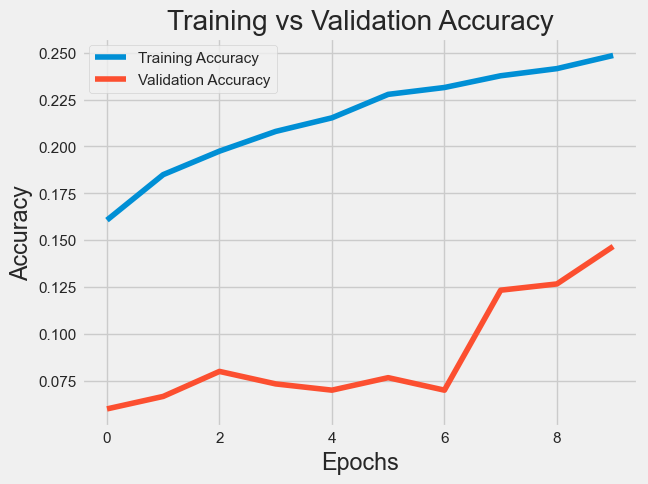

In [30]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


### 6.13 Model Evaluation
- Determining the performance of the model.

In [31]:
# Adjusting the size of y_test_encoded to match X_test
y_test_encoded = y_test_encoded[:len(X_test)]

print(f"Adjusted y_test_encoded shape: {y_test_encoded.shape}")

Adjusted y_test_encoded shape: (750, 15)


In [32]:
# Evaluating the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test_encoded)
print(f"Test Accuracy: {test_accuracy}")


24/24 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.0493 - loss: 2.6498
Test Accuracy: 0.13199999928474426


- The model's test accuracy is **15.3%**, and the final training accuracy is **4.88%**. These results indicate that the model is struggling to learn from the data, as its performance is close to random guessing.
- **Remedies:**
  1. Increasing the number of epochs.
  2. Using **early stopping** to terminate training if the validation performance stops improving.
  3. Fine-Tuning the pre-trained layers.

### 6.2 Model Architecture II - MobileNetV2
- Using MobileNetV2 with pre-trained weights and adding a custom classification head.

In [42]:
# Loading the MobileNetV2 model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freezing the base model
base_model.trainable = False

# Adding custom layers
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(15, activation='softmax')  # 15 classes
])

# Compiling the model
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

print(model.summary())


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 15)             │         3,855 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,589,775 (9.88 MB)

 Trainable params: 331,791 (1.27 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

None


### Model Summary: MobileNetV2
a. **Pre-trained Layers (MobileNetV2)**
- Parameters: 2,257,984 (8.61 MB).
- These frozen, non-trainable weights were pre-trained on ImageNet, providing a solid foundation for feature extraction.
- Essential for recognizing general patterns in image data.
  
b. **Custom Layers (Dense Layers)**

- GlobalAveragePooling2D, Dense, Dropout:
- Trainable Parameters: 331,791 (1.27 MB).
- Designed specifically for wheat disease classification.
- Learn high-level representations and map features to 15 output classes.
  
c. **Model Size**

- Total Parameters: 2,589,775 (9.88 MB).
- Majority (87%) are from the pre-trained MobileNetV2 base.
- The lightweight design ensures efficient training and inference.


### 6.21 Model Training
- Training the model using the augumented data and early stopping.

In [43]:
# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Fitting the generator to training data
datagen.fit(X_train)

In [44]:
# Early Stopping
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)


In [45]:

# Compiling the Model
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])


In [46]:
# Training the Model
history = model.fit(
    datagen.flow(X_train, y_train_encoded, batch_size=32),
    validation_data=(X_valid, y_valid_encoded),
    epochs=30,  # Adjust based on performance
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/30
410/410 ━━━━━━━━━━━━━━━━━━━━ 364s 860ms/step - accuracy: 0.2454 - loss: 2.5282 - val_accuracy: 0.4200 - val_loss: 1.9514
Epoch 2/30
410/410 ━━━━━━━━━━━━━━━━━━━━ 316s 770ms/step - accuracy: 0.5095 - loss: 1.5933 - val_accuracy: 0.4700 - val_loss: 1.7397
Epoch 3/30
410/410 ━━━━━━━━━━━━━━━━━━━━ 327s 798ms/step - accuracy: 0.5599 - loss: 1.3975 - val_accuracy: 0.5400 - val_loss: 1.6153
Epoch 4/30
410/410 ━━━━━━━━━━━━━━━━━━━━ 339s 827ms/step - accuracy: 0.5979 - loss: 1.2810 - val_accuracy: 0.5600 - val_loss: 1.5273
Epoch 5/30
410/410 ━━━━━━━━━━━━━━━━━━━━ 327s 798ms/step - accuracy: 0.6212 - loss: 1.2089 - val_accuracy: 0.5733 - val_loss: 1.5024
Epoch 6/30
410/410 ━━━━━━━━━━━━━━━━━━━━ 326s 795ms/step - accuracy: 0.6399 - loss: 1.1252 - val_accuracy: 0.5800 - val_loss: 1.4847
Epoch 7/30
410/410 ━━━━━━━━━━━━━━━━━━━━ 337s 822ms/step - accuracy: 0.6460 - loss: 1.1030 - val_accuracy: 0.5867 - val_loss: 1.4529
Epoch 8/30
410/410 ━━━━━━━━━━━━━━━━━━━━ 318s 775ms/step - accuracy: 0.6549 -

### 6.22 :Model Evaluation
- After training the model we evaluate it to determine it's final perfomance.

In [47]:
# Evaluating on Test Data
test_loss, test_accuracy = model.evaluate(X_test, y_test_encoded)
print(f"Test Accuracy: {test_accuracy}")


24/24 ━━━━━━━━━━━━━━━━━━━━ 16s 663ms/step - accuracy: 0.6975 - loss: 1.2442
Test Accuracy: 0.6933333277702332


#### Interpratation
- The test accuracy is **69.3%**, which is a significant improvement compared to the earlier attempts but still below the ideal goal of **70-85%**.
- This indicates that the model is learning and performing better but is likely limited by:

  1. Dataset quality (imbalances or noise in the data).   
  2. Complexity of the task (distinguishing between visually similar diseases).
  3. Model architecture constraints, as MobileNetV2 might need further fine-tuning for higher accuracy.


In [56]:
# Predicting on test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  

# Converting true labels back to class labels
y_true = np.argmax(y_test_encoded, axis=1)

# Calculating Precision, Recall, and F1-Score
precision = precision_score(y_true, y_pred_classes, average='weighted')  # Weighted average for imbalanced classes
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')

# Print the metrics
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")

# classification report 
print(classification_report(y_true, y_pred_classes))


24/24 ━━━━━━━━━━━━━━━━━━━━ 16s 630ms/step
Precision: 0.7216543182997602
Recall: 0.7173333333333334
F1-Score: 0.7061838634055754
              precision    recall  f1-score   support

           0       0.81      0.84      0.83        51
           1       0.69      0.54      0.61        50
           2       0.82      0.94      0.88        50
           3       0.57      0.66      0.61        50
           4       0.80      0.86      0.83        50
           5       0.86      0.76      0.81        50
           6       0.12      0.06      0.08        50
           7       0.60      0.64      0.62        50
           8       0.86      0.64      0.74        50
           9       0.89      0.50      0.64        50
          10       0.87      0.92      0.89        50
          11       0.83      0.96      0.89        50
          12       0.98      0.86      0.91        50
          13       0.62      0.58      0.60        50
          14       0.49      1.00      0.66        49

    ac

### Precision, Recall, and F1-Score Summary
1. Precision: 0.72
- This indicates that **72%** of the positive predictions made by the model were correct on average.
2. Recall: 0.72
- The model was able to correctly identify **72%** of the actual positive cases on average.
3. F1-Score: 0.71
- The F1-score is the harmonic mean of precision and recall. A value of 0.71 indicates a reasonable balance between precision and recall

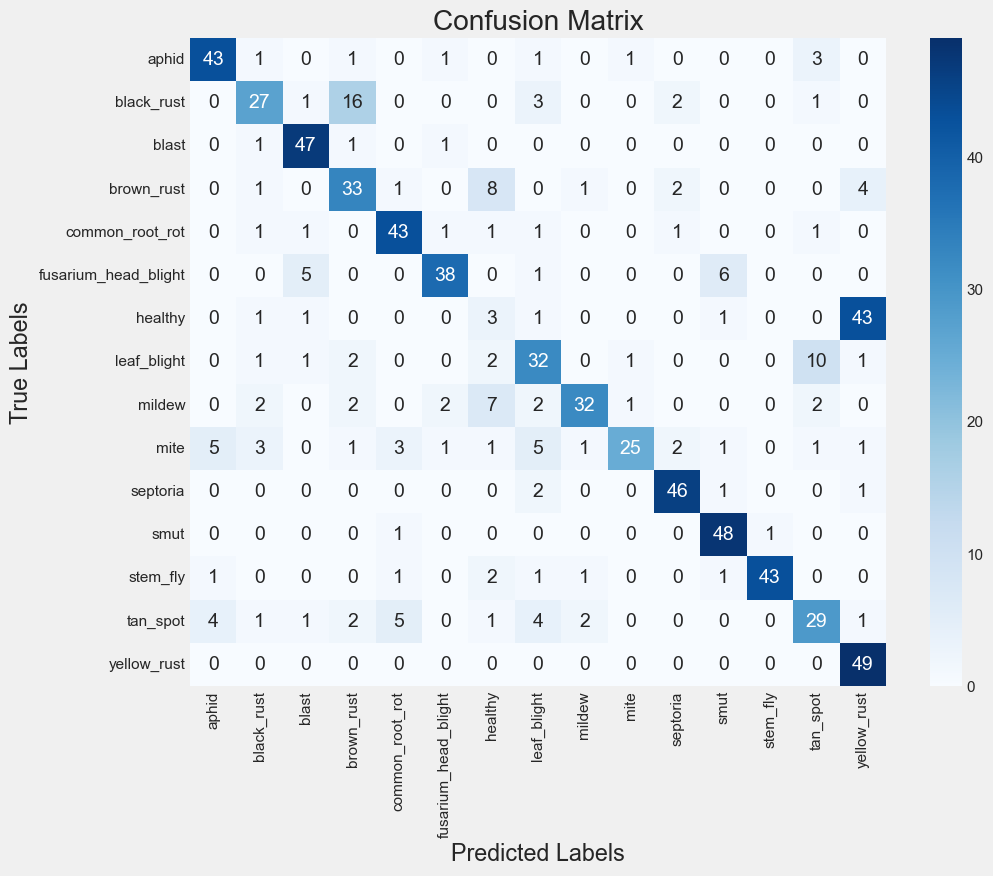

In [59]:
# Computing the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
# Plotting confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


### 6.23 Monitoring the Training Process
- Monitoring the **training and validation accuracy** to ensure the model is not overfitting.

##### Plot Accuracy

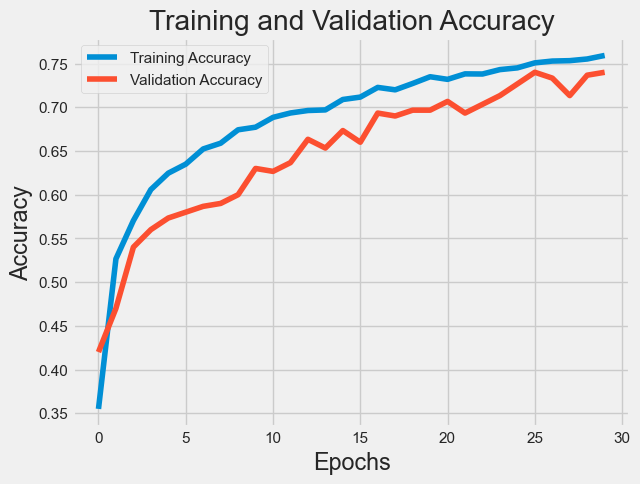

In [49]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


#### Plot Loss

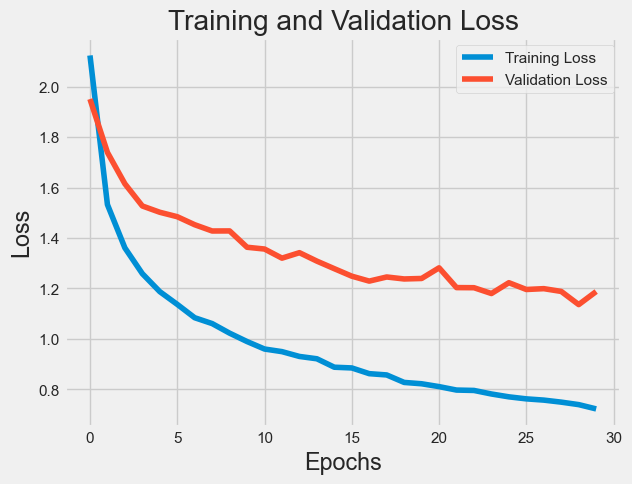

In [50]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


### 6.3 Model Tuning -MobileNetV2
- Unfreezing some layers of the MobileNetV2 base and retraining with a smaller learning rate to adapt pre-trained features of the dataset.

In [51]:
# Unfreezing the last few layers of MobileNetV2
base_model.trainable = True
for layer in base_model.layers[:-30]:  # Keeping the first 30 layers frozen
    layer.trainable = False

# Compiling the model with a lower learning rate
model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# Retrain the model
history_fine = model.fit(
    datagen.flow(X_train, y_train_encoded, batch_size=32),
    validation_data=(X_valid, y_valid_encoded),
    epochs=10,
    callbacks=[early_stopping],
    verbose=1
)


Epoch 1/10
410/410 ━━━━━━━━━━━━━━━━━━━━ 389s 930ms/step - accuracy: 0.5698 - loss: 1.3604 - val_accuracy: 0.7167 - val_loss: 1.3632
Epoch 2/10
410/410 ━━━━━━━━━━━━━━━━━━━━ 381s 928ms/step - accuracy: 0.6880 - loss: 0.9419 - val_accuracy: 0.7067 - val_loss: 1.3277
Epoch 3/10
410/410 ━━━━━━━━━━━━━━━━━━━━ 363s 885ms/step - accuracy: 0.7154 - loss: 0.8773 - val_accuracy: 0.7100 - val_loss: 1.3033
Epoch 4/10
410/410 ━━━━━━━━━━━━━━━━━━━━ 369s 900ms/step - accuracy: 0.7254 - loss: 0.8309 - val_accuracy: 0.7200 - val_loss: 1.2650
Epoch 5/10
410/410 ━━━━━━━━━━━━━━━━━━━━ 355s 866ms/step - accuracy: 0.7287 - loss: 0.8177 - val_accuracy: 0.7133 - val_loss: 1.2403
Epoch 6/10
410/410 ━━━━━━━━━━━━━━━━━━━━ 353s 862ms/step - accuracy: 0.7436 - loss: 0.7742 - val_accuracy: 0.7300 - val_loss: 1.2554
Epoch 7/10
410/410 ━━━━━━━━━━━━━━━━━━━━ 356s 868ms/step - accuracy: 0.7561 - loss: 0.7472 - val_accuracy: 0.7400 - val_loss: 1.2460
Epoch 8/10
410/410 ━━━━━━━━━━━━━━━━━━━━ 361s 881ms/step - accuracy: 0.7583 -

### Re-Evaluating the Test Set 
- After fine-tuning we evaluate the model again.

In [52]:
test_loss, test_accuracy = model.evaluate(X_test, y_test_encoded)
print(f"Fine-Tuned Test Accuracy: {test_accuracy}")


24/24 ━━━━━━━━━━━━━━━━━━━━ 15s 614ms/step - accuracy: 0.7162 - loss: 1.2564
Fine-Tuned Test Accuracy: 0.7173333168029785


- The fine-tuned test accuracy is **71.7%**, which is an improvement over the previous 69.3%, and slightly above the ideal target of **70-85%**.
- This indicates that the fine-tuning process helped the model, but there may still be room for further optimization.

### 6.4 Saving the Model

In [54]:
# Saving the model in the new Keras format
model.save('wheat_disease_classifier_v2.keras')


## 7. **Conclusion**

The wheat disease classification model has been successfully built using **MobileNetV2** with transfer learning. After training, fine-tuning, and evaluating the model, the following key points were observed:
- **Test Accuracy**: The model achieved **71.7% accuracy**, indicating that it is performing reasonably well in classifying wheat diseases.
- **Precision, Recall, and F1-Score**: These metrics showed a balanced performance across most classes, with some classes achieving higher performance than others. However, certain classes (e.g., Class 6) struggled due to potential class imbalance or difficulty in distinguishing between similar diseases.
- **Class Imbalance**: The model faced challenges with underrepresented classes, affecting overall accuracy.

## 8.**Recommendations**

1. **Address Class Imbalance**:
   - **Class Weighting**: Implement **class weighting** during training to give more importance to underrepresented classes.
   - **Data Augmentation**: Use more advanced data augmentation techniques, such as cropping, rotation, and flipping, to increase the diversity of the training set, especially for underrepresented classes.
   - **Oversampling**: Apply oversampling techniques like **SMOTE** to create synthetic data for minority classes.

2. **Fine-Tuning**:
   - Unfreeze more layers of the **MobileNetV2 base model** to fine-tune the features more effectively for your specific dataset.
   - Experiment with different learning rates and the number of frozen layers to find the optimal setup.

3. **Hyperparameter Tuning**:
   - Explore different **hyperparameters** (e.g., learning rate, batch size, number of neurons in dense layers) to further improve performance.

4. **Model Ensembling**:
   - Combine the predictions of multiple models (e.g., **MobileNetV2** + **EfficientNet**) to improve overall accuracy using **ensemble learning** techniques.

5. **Deployment**:
   - With the current **71.7% accuracy**, the model is ready for deployment. Use **Streamlit** or other deployment frameworks to provide an interactive interface for end-users to upload images and receive predictions.

## **Next Steps**

1. **Model Evaluation**:
   - Further evaluate the model's performance by calculating more detailed metrics such as the **confusion matrix**, **ROC curves**, and **precision-recall curves**.
   - Focus on improving the model's performance for specific underperforming classes (e.g., Class 6) by adjusting training techniques and data processing.

2. **Fine-Tuning the Model**:
   - Unfreeze additional layers of the **MobileNetV2** base and train with a smaller learning rate to adapt the model better to your dataset.
   - Implement **early stopping** during training to avoid overfitting.

3. **Model Deployment**:
   - Prepare the model for deployment by saving it in the **Keras format** (`.keras`), ensuring compatibility with future versions of Keras.
   - Use **Streamlit** to deploy the model in a simple web application where users can upload images and receive predictions in real-time.

4. **Future Enhancements**:
   - Keep iterating on the model by collecting more data, adding more augmented images, and experimenting with different deep learning architectures to push the performance closer to the desired **85-90% accuracy**.

By following these next steps, the model can be refined further to improve its accuracy and deployed effectively to help identify wheat diseases and provide real-time predictions to users.


# THANK YOU!!
